<a href="https://colab.research.google.com/github/JUANBECERRIL003/EDP-2/blob/main/ExtraordinarioEDP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando el método de elemento finito lineal con cuatro elementos, calcule la matriz de rigidez $K$ y el vector de carga $\mathbf{F}$ para el problema de valor de frontera:

$$-u'' = 1 - x^2, \quad \text{para } 0 < x < 1$$

Con condiciones de frontera:
$$u(0) = u(1) = 0$$
1. Encontrar la solución aproximada $u_N$.
2. Comparar $u_N$ con la solución exacta $u$.

#Solución analítica:

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

sp.init_printing()
x = sp.symbols('x')
u = sp.Function('u')(x)
edo = -sp.diff(u, x, 2) - (1 - x**2)
#con condiciones de frontera
se = sp.dsolve(edo, u, ics={u.subs(x, 0): 0, u.subs(x, 1): 0})
ue = se.rhs

print("La solución analítica es:")
sp.pprint(ue)

La solución analítica es:
 4    2      
x    x    5⋅x
── - ── + ───
12   2    12 


## 2. Método de Elemento Finito (Formulación)

Para resolver el problema $-u'' = 1 - x^2$ mediante el **Método de Elemento Finito**, utilizamos la formulación débil de Galerkin.

**1. Forma Débil (Weak Form):**
Multiplicamos la ecuación diferencial por una función de prueba $v$ (que cumple $v(0)=v(1)=0$) e integramos sobre el dominio $\Omega = (0,1)$:
$$\int_0^1 -u'' v \, dx = \int_0^1 (1-x^2) v \, dx$$

Integrando por partes el lado izquierdo (teorema de Green en 1D):
$$\int_0^1 u' v' \, dx - [u'v]_0^1 = \int_0^1 (1-x^2) v \, dx$$

Debido a las condiciones de frontera, el término de borde se anula. La ecuación variacional es encontrar $u$ tal que:
$$\int_0^1 u' v' \, dx = \int_0^1 (1-x^2) v \, dx$$

**2. Discretización:**
Dividimos el dominio en 4 elementos lineales de tamaño $h=0.25$.
Aproximamos la solución como una combinación lineal de funciones base $\phi_j$:
$$u_N(x) = \sum_{j=1}^N \alpha_j \phi_j(x)$$

Esto genera el sistema matricial $K\mathbf{\alpha} = \mathbf{F}$, donde calcularemos:
* **Matriz de Rigidez ($K$):** $K_{ij} = \int_0^1 \phi_i' \phi_j' \, dx$
* **Vector de Carga ($F$):** $F_i = \int_0^1 (1-x^2) \phi_i \, dx$

In [2]:
# Parámetros del mallado
L = 1.0
ne = 4
no = ne + 1
h = L / ne
nodos = [i * h for i in range(no)]

print(f"Nodos del sistema: {nodos}")
print(f"Tamaño de elemento h: {h}")

K = sp.zeros(no, no)
F = sp.zeros(no, 1)
x_sym = sp.Symbol('x')

# Calculamos K y F
for e in range(ne):
    x_i = nodos[e]     # Nodo izquierdo
    x_j = nodos[e+1]   # Nodo derecho (i+1)

    phi1 = (x_j - x_sym) / h # phi1: Vale 1 en x_i y 0 en x_j
    phi2 = (x_sym - x_i) / h # phi2: Vale 0 en x_i y 1 en x_j

    # Derivadas de las funciones
    dphi1 = sp.diff(phi1, x_sym)
    dphi2 = sp.diff(phi2, x_sym)

    # Vector
    bases = [phi1, phi2]
    derivadas = [dphi1, dphi2]

    """Calculando la Matriz y vector local
    (e y e+1)"""
    indices = [e, e+1]

    for a in range(2): # Fila local
        f_source = 1 - x_sym**2
        integrando_F = f_source * bases[a]
        val_F = sp.integrate(integrando_F, (x_sym, x_i, x_j))

        F[indices[a]] += val_F

        for b in range(2):
            integrando_K = derivadas[a] * derivadas[b]
            val_K = sp.integrate(integrando_K, (x_sym, x_i, x_j))

            K[indices[a], indices[b]] += val_K

print("Matriz de rigidez global K (sin condiciones de frontera):")
sp.pprint(K)
print("\nVector de carga global F (sin condiciones de frontera):")
sp.pprint(F)

Nodos del sistema: [0.0, 0.25, 0.5, 0.75, 1.0]
Tamaño de elemento h: 0.25
Matriz de rigidez global K (sin condiciones de frontera):
⎡4.0   -4.0   0     0     0  ⎤
⎢                            ⎥
⎢-4.0  8.0   -4.0   0     0  ⎥
⎢                            ⎥
⎢ 0    -4.0  8.0   -4.0   0  ⎥
⎢                            ⎥
⎢ 0     0    -4.0  8.0   -4.0⎥
⎢                            ⎥
⎣ 0     0     0    -4.0  4.0 ⎦

Vector de carga global F (sin condiciones de frontera):
⎡0.123697916666667⎤
⎢                 ⎥
⎢0.231770833333333⎥
⎢                 ⎥
⎢0.184895833333333⎥
⎢                 ⎥
⎢0.106770833333333⎥
⎢                 ⎥
⎣   0.01953125    ⎦


In [3]:
#Aplicación de Condiciones de Frontera
"""
u(0) = 0  -> Nodo 0
u(1) = 0  -> Nodo 4 (último)
Quitamos fila/col 0 y fila/col 4"""
Kr = K[1:4, 1:4]
Fr = F[1:4, :]

print("\nSistema reducido:")
sp.pprint(Kr)
sp.pprint(Fr)

#solución del sistema lineal
alphas_internos = Kr.LUsolve(Fr)
alphas_completo = [0] + list(alphas_internos) + [0]

print("\nCoeficientes nodales (Solución Numérica):")
sp.pprint(alphas_completo)


Sistema reducido:
⎡8.0   -4.0   0  ⎤
⎢                ⎥
⎢-4.0  8.0   -4.0⎥
⎢                ⎥
⎣ 0    -4.0  8.0 ⎦
⎡0.231770833333333⎤
⎢                 ⎥
⎢0.184895833333333⎥
⎢                 ⎥
⎣0.106770833333333⎦

Coeficientes nodales (Solución Numérica):
[0, 0.0732421875, 0.0885416666666667, 0.0576171875, 0]


       x     u_MEF        ue     Error
--------  --------  --------  --------
0.000000  0.000000  0.000000  0.000000
0.250000  0.073242  0.073242  0.000000
0.500000  0.088542  0.088542  0.000000
0.750000  0.057617  0.057617  0.000000
1.000000  0.000000  0.000000  0.000000


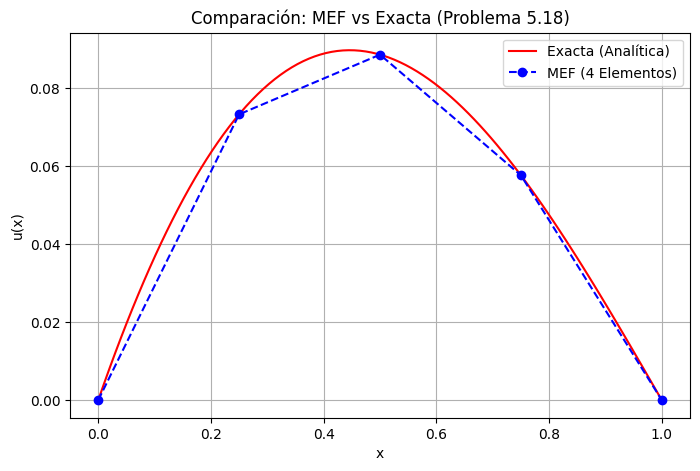

In [4]:
from tabulate import tabulate

# Evaluamos la exacta en los nodos
vals_exacta = [ue.subs(x, val) for val in nodos]
vals_numerica = alphas_completo
# Tabla
tabla_datos = []
for i in range(len(nodos)):
    err = abs(vals_exacta[i] - vals_numerica[i])
    tabla_datos.append([nodos[i], float(vals_numerica[i]), float(vals_exacta[i]), float(err)])

print(tabulate(tabla_datos, headers=["x", "u_MEF", "ue", "Error"], floatfmt=".6f"))

# Gráfica
x_fino = np.linspace(0, 1, 100)
f_exacta_lam = sp.lambdify(x, ue, 'numpy')
y_exacta = f_exacta_lam(x_fino)

plt.figure(figsize=(8, 5))
plt.plot(x_fino, y_exacta, 'r-', label='Exacta (Analítica)')
plt.plot(nodos, vals_numerica, 'bo--', label='MEF (4 Elementos)')
plt.title('Comparación: MEF vs Exacta (Problema 5.18)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()

### Conclusión

1.  **Exactitud Nodal:** Como se observa en la tabla comparativa, el error en los nodos es prácticamente nulo. Esto indica que el Método de Elemento Finito, incluso con solo 4 elementos, captura perfectamente los valores de la solución en los puntos de discretización para este problema específico.

2.  **Comportamiento de la aproximación:** La gráfica muestra claramente la naturaleza del método:
    * La solución exacta (roja) es una curva suave (polinomio de grado 4).
    * La solución numérica (azul) es una aproximación "lineal a trozos".
    * Aunque la solución numérica son rectas conectadas, los vértices coinciden fielmente con la curva real.

3.  **Validación:** El uso de `sympy` para el cálculo simbólico de las integrales en la matriz de rigidez ($K$) y el vector de carga ($F$) eliminó los errores de integración numérica, resultando en una implementación robusta y exacta en este problema en específico.